# Mini Project 2: Generating the initial filters for a CNN

We are at the stage where we can look into using custom filters much like for the MLP model. However, this time using the MS Paint GUI is giving the opposite problem - for small filter sizes such as 3x3 square pixels, the MS Paint GUI is much more difficult to use and draw properly.

Therefore, we will use the tkinter GUI that I made, which was the first attempt at making a GUI for the MLP part of the project. This time, since the filter sizes are much smaller than the size of the images, and the tkinter GUI can render at a much larger size than the MS Paint filters, we will use it in order to make the filters.

Previously, the way the GUI worked was using one click to turn a zero weight into a positive weight, another click to turn that positive weight to a negative weight, and then a final click to turn a negative weight to a zero weight, which created a cycle. For better interactivity, instead I will make two click functions, one for left click and another for right click, which will save even more time.

In [1]:
'''
Program used to generate the initial weights via a GUI interaction. The
GUI appears, and the user can assign positive and negative initial
weights to specific pixels on the grid.
'''
import os
import tkinter as tk
import numpy as np
from enum import Enum
from PIL import Image

Previously, we had a click function with a lambda expressions involving the x and y positions on the grid, as well as the local variables grid_var (the grid of buttons) and click_state (an array of the same shape as the grid, but with the values of the weights). However, using the .bind method to bind commands to specific button presses must only be a function of the event, which is a class in tkinter that contains information about what button was clicked as well as how it was clicked.

Since I cannot pass in a click_state variable into this function, nor can I instantiate and fill in the click_state values after mainloop() is closed (since the method calls to get the values from the buttons do not work after mainloop() is closed), I have opted to set CLICK_STATE as a global variable, which can be edited by a click function that is only a function of the event.

In [2]:
class ClickState(Enum):
    '''
    This class gives us a way of labelling the click states
    that is more readable.
    
    OFF (0) represents an unclicked button, and is the
    default option.
    POSITIVE (1) represents a button left clicked. This will
    attribute a positive weight to the weights at the end of the code.
    NEGATIVE (-1) represents a button right clicked. This will
    attribute a negative weight to the weights at the end of the code.
    '''
    
    OFF = 0
    POSITIVE = 1
    NEGATIVE = -1
       
def click(event):
    '''
    click function using the tkinter event class.
    Changes the state of the buttons in mainloop(),
    as well as changes the state of the global variable
    CLICK_STATE when a button is left
    or right clicked.
    
    For left clicking:
    off -> positive
    positive -> off
    negative -> positive
    
    For right clicking:
    off -> negative
    negative -> off
    positive -> negative
    '''
    global CLICK_STATE
    # Getting the position of the button
    # in the flattened grid.
    button_var = str(event.widget)
    if button_var[-1] == 'n':
        button_var = 0
    else:
        button_var = int(button_var[-1]) - 1

    # Getting the current button state
    # from the click_state.
    current_button_state = CLICK_STATE[button_var]  
          
    # State transitions, with branching
    # based off of left or right click.
    if current_button_state == ClickState.POSITIVE.value:
        # Left click on positive values changes
        # the clicked button to off. Right click
        # on positive values changes the clicked
        # button to negative.
        if event.num == 1:
            event.widget.configure(bg = 'SystemButtonFace', text = '')
            CLICK_STATE[button_var] = ClickState.OFF.value
        elif event.num == 2 or event.num == 3:
            event.widget.configure(bg = 'red', text = str(ClickState.NEGATIVE.value))
            CLICK_STATE[button_var] = ClickState.NEGATIVE.value

    elif current_button_state == ClickState.NEGATIVE.value:
        # Left click on negative values changes
        # the clicked button to positive. Right click
        # on negative values changes the clicked
        # button to off.
        if event.num == 1:
            event.widget.configure(bg = 'cyan', text = '+' + str(ClickState.POSITIVE.value))
            CLICK_STATE[button_var] = ClickState.POSITIVE.value
        elif event.num == 2 or event.num == 3:
            event.widget.configure(bg = 'SystemButtonFace', text = '')
            CLICK_STATE[button_var] = ClickState.OFF.value

    elif current_button_state == ClickState.OFF.value:
        # Left click on off values changes
        # the clicked button to positive. Right click
        # on off values changes the clicked
        # button to negative.
        if event.num == 1:
            event.widget.configure(bg = 'cyan', text = '+' + str(ClickState.POSITIVE.value))
            CLICK_STATE[button_var] = ClickState.POSITIVE.value

        elif event.num == 2 or event.num == 3:
            event.widget.configure(bg = 'red', text = str(ClickState.NEGATIVE.value))
            CLICK_STATE[button_var] = ClickState.NEGATIVE.value

In [3]:
def run_ini_weights_gui(n_x = 3, n_y = 3, tol_var = 1E-6):
    '''
    Runs the GUI for setting the initial weights. Uses the click(event)
    function defined above.
    '''

    # grid_var is a list of buttons.
    grid_var = [[0 for i in range(n_x)] for j in range(n_y)]
    root = tk.Tk()
    height_var = 15
    # Iterating over the rows and columns.
    for row_val in range(n_x):
        for col_val in range(n_y):
            grid_var[row_val][col_val] = tk.Button(root,
                                                   height = height_var,
                                                   width = 2*height_var,
                                                   text = '')
            # "<Button-1>" is left click, either "<Button-2>" or "<Button-3>"
            # can be right click.
            grid_var[row_val][col_val].bind("<Button-1>", click)
            grid_var[row_val][col_val].bind("<Button-2>", click)
            grid_var[row_val][col_val].bind("<Button-3>", click)
            # Placing the button on the grid.
            grid_var[row_val][col_val].grid(row = row_val, column = col_val)
    root.mainloop()
    
    return list_to_weights(list_var = CLICK_STATE, tol_var = tol_var)    

In [4]:
def list_to_weights(list_var, tol_var = 1E-6):
    '''
    Converts a list of weights into numpy array,
    and turns values with absolute value less than
    tol_var into tol_var. This is to allow some
    learning even if the weights are near zero.
    '''
    global CLICK_STATE
    ini_weights = np.array(list_var, dtype = np.float_)
    # Reshaping into a 1D array. The .flatten() method returns a copy, and
    # does not perform the flattening in place!
    ini_weights = ini_weights.flatten()

    # Since weights that are zero will not change via back-propagation,
    # we assign weights with absolute values less than tol_var as equal to that tolerance.
    # This will allow them to change as the ANN learns.
    for index, weight in enumerate(ini_weights):
        if abs(weight) < tol_var:
            ini_weights[index] = tol_var
    return ini_weights

In [5]:
N_X = 3
N_Y = 3
CLICK_STATE = [ClickState.OFF.value for i in range(N_X*N_Y)]
WEIGHTS = run_ini_weights_gui()
# For negative edges.
INV_WEIGHTS = -WEIGHTS
# Printing the elements of the WEIGHTS array.
for INDEX, WEIGHT in enumerate(WEIGHTS):
    print('i = {}, weights = {}, {}'.format(INDEX, WEIGHT, INV_WEIGHTS[INDEX]))

i = 0, weights = -1.0, 1.0
i = 1, weights = -1.0, 1.0
i = 2, weights = -1.0, 1.0
i = 3, weights = 1.0, -1.0
i = 4, weights = 1.0, -1.0
i = 5, weights = 1.0, -1.0
i = 6, weights = 1e-06, -1e-06
i = 7, weights = 1e-06, -1e-06
i = 8, weights = 1e-06, -1e-06


As we can see, the GUI runs nicely and can be scaled to our liking. Since drag click is very unreliable on small filter sizes in MS Paint, one saves a lot of time by using this tkinter GUI for small filters. Next, we will produce more code to run this multiple times for the different filters, and save the results to .dat files.

To do this, I may want to return after multiple sessions to add more filters that I come up with. Therefore, I need a system that allows me to visualise the files in my folder, so I can more easily see what filters I have done already. Repeats are not the end of the world, but they do increase computation time. Luckily, I have functions that convert weights into a graphical image.

In [6]:
def weights_to_pixels(weights, max_weight = 1.0, mode = 'filter'):
    '''
    This is a function that takes in the weights of a single node in
    the first hidden layer, and changes them into an image. This should
    be used to test the output of the pixel_to_weight() method above,
    but it can also be used to generate pictures of the distribution of
    weights after the ANN has converged.
    '''

    global N_X, N_Y

    # On input, weights are a 1D array or list. We can reshape it into
    # a 2D array in order for easier indexing.

    # Since weights are generated from image files, they have
    # column major ordering.
    if mode == 'weight':
        weights_2d = np.array(weights).reshape((N_X,N_Y))
    # However, for our filters generated from buttons, the
    # buttons are named in row major ordering. Therefore,
    # we perform a transpose to get the desired image.
    else:
        weights_2d = np.array(weights).reshape((N_X,N_Y)).transpose()
    with Image.new('RGB', (N_X,N_Y), 'white') as out_image:
        pixels_var = out_image.load()
        # Now iterating over the width and height.
        for i in range(N_X):
            for j in range(N_Y):
                pixels_var[i,j] = weight_to_pixel(weight_var = weights_2d[i,j], max_weight = max_weight)

        return out_image


def weight_to_pixel(weight_var, accur_var = 14, max_weight = 1.0):
    '''
    This function converts a singular weight value to a pixel.
    Rounding is necessary to map cyan to the proper pixel value.
    accur_var controls the accuracy of the round() method.
    '''

    # If the weight is less than or equal to zero, then we take the
    # absolute value of that weight in terms of red.
    # If the weight is greater than zero, then we take the value of the
    # weight in terms of cyan.
    if weight_var <= 0:
        return (int(255.0*abs(round(weight_var,accur_var))/max_weight),0,0)
    return (0,int(255.0*round(weight_var,accur_var)/max_weight),\
                int(255.0*round(weight_var,accur_var)/max_weight))

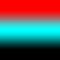

In [7]:
# Since the image is very small in this case,
# we can resize it to get an idea of what filters
# we have already done.
weights_to_pixels(weights = WEIGHTS).resize(size = (60,60))

In [8]:
# Run this cell to generate the weights
# and inverse weights.
FILE_PATH = os.getcwd()
FILE_PATH += '\\Initial Filters\\test_1'

# If the file exists, we read in the current
# number of filters in the folder.
# Else, we set the number of filters in the folder
# to zero.
try:
    with open(FILE_PATH + "\\filter_count.txt", "r") as FILE:
        N_FILTERS = int(FILE.read())
except FileNotFoundError:
    N_FILTERS = 0
    
CLICK_STATE = [ClickState.OFF.value for i in range(N_X*N_Y)]
WEIGHTS = run_ini_weights_gui()
# For negative edges.
INV_WEIGHTS = -WEIGHTS
WEIGHTS_IMAGE = weights_to_pixels(weights = WEIGHTS).resize(size = (60,60))
INV_WEIGHTS_IMAGE = weights_to_pixels(weights = INV_WEIGHTS).resize(size = (60,60))

N_FILTERS += 1
FILE_OUT_1 = FILE_PATH + "\\filter_{}".format(N_FILTERS)
FILE_OUT_2 = FILE_PATH + "\\image_{}.png".format(N_FILTERS)
np.savetxt(fname = FILE_OUT_1, X = WEIGHTS)
WEIGHTS_IMAGE.save(FILE_OUT_2)

N_FILTERS += 1
FILE_OUT_1 = FILE_PATH + "\\filter_{}".format(N_FILTERS)
FILE_OUT_2 = FILE_PATH + "\\image_{}.png".format(N_FILTERS)
np.savetxt(fname = FILE_OUT_1, X = INV_WEIGHTS)
INV_WEIGHTS_IMAGE.save(FILE_OUT_2)
    
with open(FILE_PATH + "\\filter_count.txt", "w") as FILE:
    FILE.write(str(N_FILTERS))